## Simple Mapping and Network Creation

This notebook uses the derived CSV file to make a static map of all structures and an interactive map of the same. It then generates geodesic distances between all amphitheaters and creates a network of the closest ones. Last step maps that network.

If you're viewing this on GitHub, the interactive versions don't show (at least not for me). They need to be viewed locally.


In [2]:
import contextily as ctx
import geopandas as gpd
from geopy.distance import geodesic
from holoviews import dim, opts
import holoviews as hv
import hvplot.pandas
import hvplot.networkx as hvnx
import itertools
import json
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph
import pandas as pd

In [3]:
# load the data
url = 'https://roman-amphitheaters.github.io/roman-amphitheaters/roman-amphitheaters.csv'
df = pd.read_csv(url)
df.set_index('id', inplace=True, drop=False)

### Mapping

In [4]:
# create a geodataframe and convert to web mercator
gdf_4326 = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))
gdf_3857 = gdf_4326.to_crs('epsg:3857')

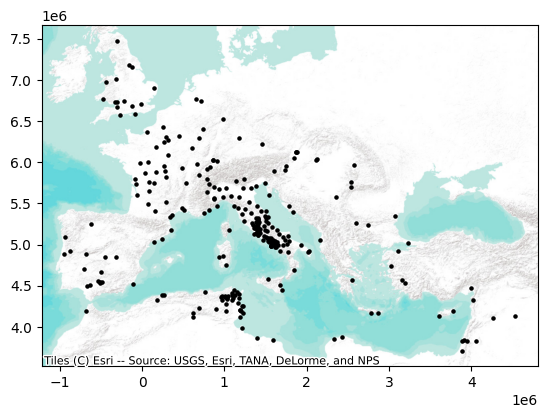

In [4]:
# static map. If anyone knows of a good open source terrain basemap, let me know. One w/o labels.
ax = gdf_3857.plot(color = 'black', markersize=5)
ctx.add_basemap(ax, crs=gdf_3857.crs.to_string(), source=ctx.providers.Esri.WorldTerrain)

In [5]:
# interactive map
all_ramphs_hvplot = gdf_3857.hvplot(tiles = "EsriTerrain", size = 10, color = 'black', hover_cols=['id', 'modcountry', 'capacity'])
all_ramphs_hvplot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [x,y]   (id,modcountry,capacity)

### As a network

In [5]:
# all pairs of amphitheaters (well, actually of all structures in the dataset. most are amphitheaters.)
ramphs_pairs_l = [p for p in itertools.combinations(list(df.index),2)]
len(ramphs_pairs_l)

36856

In [6]:
# create a list of tuples with start, end, and distance for each pair
distances_l = [ ( p[0], p[1],
              geodesic((df.loc[p[0],'latitude'], df.loc[p[0],'longitude']),
                       (df.loc[p[1],'latitude'], df.loc[p[1],'longitude'])).km )
              for p in ramphs_pairs_l ]

distances_l[0]

('duraEuroposAmphitheater', 'arlesAmphitheater', 3242.1775785038153)

In [7]:
# dataframe from list then rename columns

distances_df = pd.DataFrame(distances_l).rename(columns = {0:"source",1:"target",2:"distance"})

distances_df.head(1)

,source,target,distance
0,duraEuroposAmphitheater,arlesAmphitheater,3242.177579


In [8]:
# create a df of the closest "amphitheater" pairs
edge_threshold = distances_df['distance'].quantile(0.025)
edgelist_df = distances_df[distances_df['distance'] <= edge_threshold]

print(edge_threshold)

edgelist_df.head(1)

86.4043377650017


,source,target,distance
312,arlesAmphitheater,nimesAmphitheater,27.97827


In [8]:
# dictionary of id and coordinates. for use as a pos parameter when drawing the networkx graph
pos_3857 = {t.id:(t.geometry.x,t.geometry.y) for t in gdf_3857[['id','geometry']].itertuples()}

In [13]:
# create a network and add centrality measures
G = nx.from_pandas_edgelist(edgelist_df, 'source', 'target', ['distance'])

# add centrality measures
centrality_measures = {
    'degree_centrality': nx.degree_centrality(G),
    'closeness_centrality': nx.closeness_centrality(G),
    'betweenness_centrality': nx.betweenness_centrality(G),
    'eigenvector_centrality': nx.eigenvector_centrality(G, max_iter=1000)
}

for name, centrality in centrality_measures.items():
    try: nx.set_node_attributes(G, centrality, name)
    except: pass

# add degree
nx.set_node_attributes(G, dict(G.degree()), 'degree')

color_by = 'degree_centrality'
size_by = 'degree_centrality'

g_distance_hvplot = hvnx.draw(G, pos = pos_3857, node_color=dim(color_by), cmap = 'Reds',
                               node_size=(dim(size_by)*250)+10,
                               edge_alpha = 1, edge_line_width=0.5)

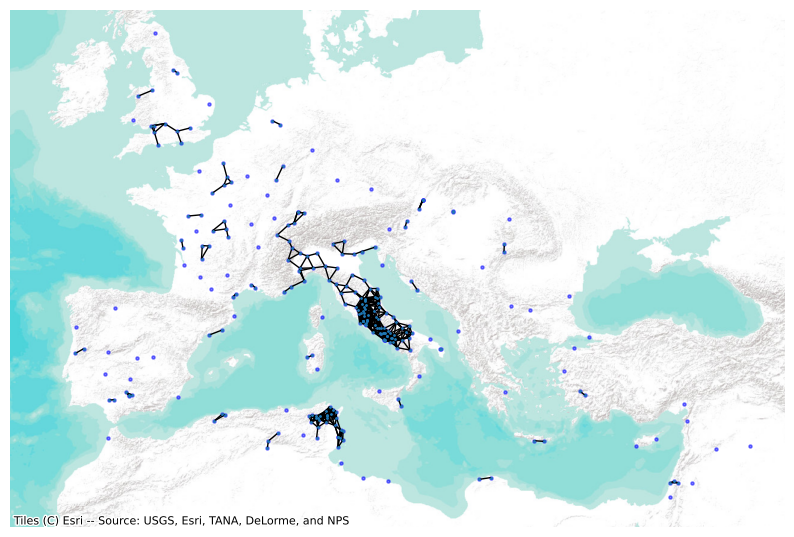

In [12]:
# static rendering. nx.draw can't go first as it doesn't return an ax object. use gdf_3857.plot() to set that up.

nx_ax = gdf_3857.plot( color = 'b', markersize = 5, alpha = .5, figsize=(10,10))
nx.draw(G,pos_3857, node_size = 1, ax = nx_ax)
ctx.add_basemap(nx_ax, crs=gdf_3857.crs.to_string(), source=ctx.providers.Esri.WorldTerrain)

In [13]:
# plot that network on top of the interactive map

title = f"Max edge distance: {int(edge_threshold)} km. Color by {color_by}. Size by {size_by}."

(all_ramphs_hvplot * g_distance_hvplot).opts(height=600, width=800, title = title)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [x,y]   (id,modcountry,capacity)
   .Graph.I  :Graph   [start,end]   (distance)

### Export to HTML
Output can be viewed at https://roman-amphitheaters.github.io/roman-amphitheaters/ramphs-simple-maps-network.html 

In [14]:

text_box = 'Data: http://github.com/roman-amphitheaters/roman-amphitheaters'

hvplot.save((all_ramphs_hvplot * g_distance_hvplot * hv.Text(2000000, 3500000,text_box)).opts(height = 600, width = 800,
             title=f"Map of Roman Amphitheaters and Related Structures (Max edge distance: {int(edge_threshold)} km)"),
             'ramphs-simple-maps-network.html')

### Export to GeoJSON

In [9]:
pos_4326 = {t.id:(t.geometry.x,t.geometry.y) for t in gdf_4326[['id','geometry']].itertuples()}

In [10]:
edgelist_df = distances_df[distances_df['distance'] <= 100]
G = nx.from_pandas_edgelist(edgelist_df, 'source', 'target', ['distance'])

data = json_graph.node_link_data(G)

geojson = {
    "type": "FeatureCollection",
    "features": []
}

for node in data['nodes']:
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": [pos_4326[node['id']][0], pos_4326[node['id']][1]]
        },
        "properties": node
    }
    geojson['features'].append(feature)

for edge in data['links']:
    source_pos = pos_4326[edge['source']]
    target_pos = pos_4326[edge['target']]
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": [[source_pos[0], source_pos[1]], [target_pos[0], target_pos[1]]]
        },
        "properties": edge
    }
    geojson['features'].append(feature)

with open('close-amphitheaters.geojson', 'w') as outfile:
    json.dump(geojson, outfile)
